# House Prices

## 1. Load in Data

In [1]:
import os
import cv2
import scipy.stats as sci
import numpy as np
import seaborn as sns
import pandas as pd
import torch
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

In [2]:
train_df = pd.read_csv('houseprices/train.csv')
test_df = pd.read_csv('houseprices/test.csv')

train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
print(f'Number of houses in training set: {train_df.shape[0]}')
print(f'Number of houses in test set: {test_df.shape[0]}')

Number of houses in training set: 1460
Number of houses in test set: 1459


Test/train is split 50/50. Let's split the current test set into a validation AND test set, so we have a train/valid/test split of 50/25/25. This is so we can choose models and perform hyperparameter tuning using the validation set, and then obtain unbiased measures of performance using the unseen test data.

## 2. Understanding the Data (EDA)

### 2.1. Target Variable

First lets explore the target variable, 'SalePrice'.

In [4]:
## Descriptive summary

train_df[['SalePrice']].describe().round()

,SalePrice
count,1460.0
mean,180921.0
std,79443.0
min,34900.0
25%,129975.0
50%,163000.0
75%,214000.0
max,755000.0


From the descriptive summary we can see that positive skewness will be present since the mean is larger than the median relative to the standard deviation.

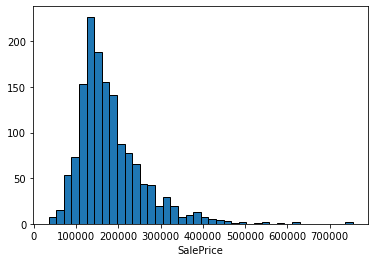

In [5]:
## Distributional summary

plt.hist(train_df['SalePrice'], bins=40, edgecolor='black')
plt.xlabel('SalePrice');

From this we can see that:
* Average saleprice is around 150,000 to 200,000 dollars
* Positive skewness is present, as predicted
* We should investigate the potential outliers at >700,000 dollars, which could be harmful to our modelling

In [6]:
# Skew and kurt

print(f"Skewness: {train_df['SalePrice'].skew().round(4)}")
print(f"Kurtosis: {train_df['SalePrice'].kurt().round(4)}")

Skewness: 1.8829
Kurtosis: 6.5363


Now, let's explore the dependant variables...

### 2.2. Dependant Variables

In [7]:
train_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In total, we have 81 variables. Let's estimate how many are categorical vs continuous.

In [8]:
## Create tables of the categorical and numerical variables. Note we drop the target and 'Id' variables

numerical_vars = train_df.drop(columns=['Id', 'SalePrice']).select_dtypes(exclude='object')
categorical_vars =  train_df.select_dtypes(include='object')

In [9]:
print(f"Number of categorical variables > {numerical_vars.shape[1]}")
print(f"Number of non-categorical variables < {categorical_vars.shape[1]}")

Number of categorical variables > 36
Number of non-categorical variables < 43


This split is by no means precise. Many categorical variables are accounted for as non-categorical since the dataset identifies some word-heavy distinctions using integers, resulting in a categorical variable being counted as an integer type. For instance in 'MSSubClass', '1-STORY 1946 & NEWER ALL STYLES' corresponds to 20. **Much more than half the variables are categorical**.

Now we can plot a correlation matrix with the hope of identifying the most useful features, as well as collinear variables.

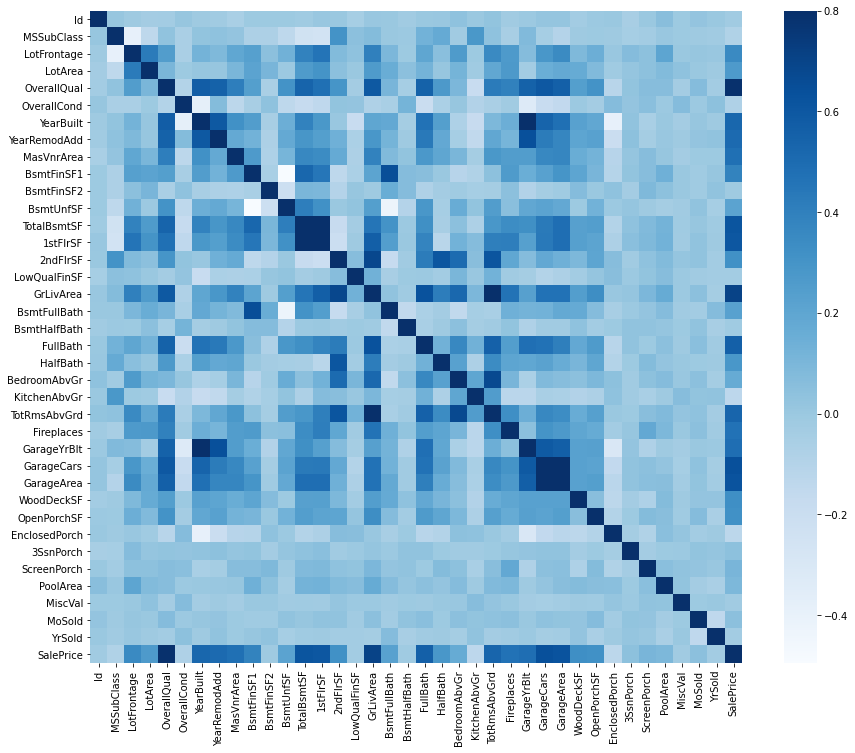

In [10]:
#correlation matrix

corrolationmat = train_df.corr()
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(corrolationmat, vmax=.8, square='True', cmap='Blues');

* 'OverallQual', TotalBsmntSF', '1stFlrSF', 'GrLivArea', 'GarageCars'  seem important to determining SalePrice
* Many of the variables are collinear, such as 'GarageArea' and 'GarageCars', unsurprisingly. We should exclude certain variables from our modelling to improve interpretability

In [11]:
## Denote top 10 significant columns as 'sigcols'

sigcols = corrolationmat.nlargest(10,'SalePrice')['SalePrice'].index
list(sigcols)

['SalePrice',
 'OverallQual',
 'GrLivArea',
 'GarageCars',
 'GarageArea',
 'TotalBsmtSF',
 '1stFlrSF',
 'FullBath',
 'TotRmsAbvGrd',
 'YearBuilt']

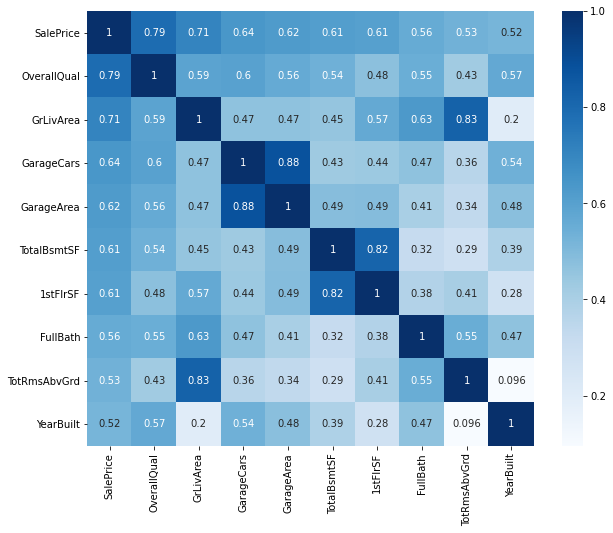

In [12]:
## Plot the heatmap of these 10 'most significant' variables

plt.figure(figsize=(10,8))
sns.heatmap(train_df[sigcols].corr(), cmap='Blues', annot=True)
plt.show()

When we begin removing variables due to collinearity, we can use the above heatmap to identify pairs.

### 2.3. Plotting Most Significant Variables

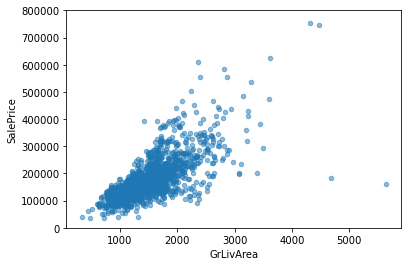

In [13]:
data = pd.concat([train_df['SalePrice'], train_df['GrLivArea']], axis=1)
data.plot.scatter(x='GrLivArea', y='SalePrice', alpha=0.5, ylim=(0,800000));

The two datapoints on the bottom right hand side appear to be ouliers. We will remove these entries

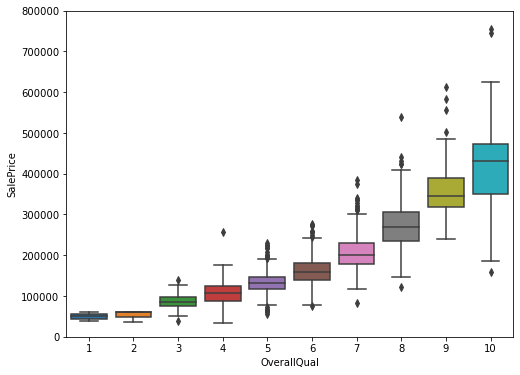

In [14]:
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x="OverallQual", y="SalePrice", data=train_df)
fig.axis(ymin=0, ymax=800000);

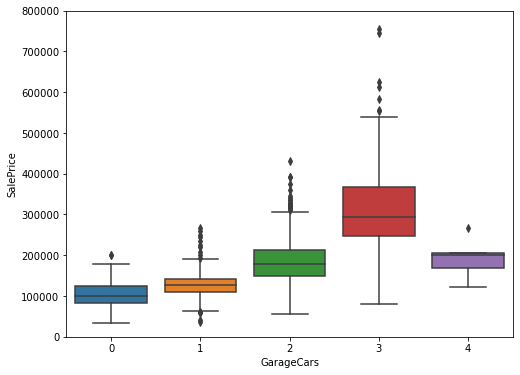

In [15]:
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x="GarageCars", y="SalePrice", data=train_df)
fig.axis(ymin=0, ymax=800000);

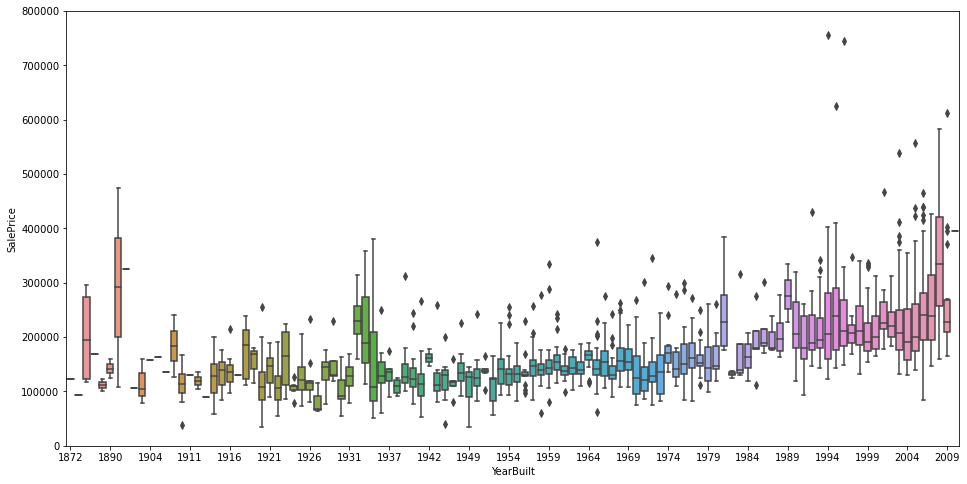

In [16]:
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x='YearBuilt', y="SalePrice", data=train_df)
fig.axis(ymin=0, ymax=800000);
plt.locator_params(axis='x', nbins=25)

  ## 3. Feature Engineering / Data Transformation

### 3.1. Removing Outliers of Training Data

Lets look at some highly influential variables to spot some outliers.

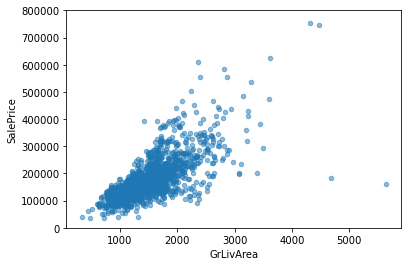

In [17]:
## As before, check the plot of 'GrLiveArea' to 'SalesPrice'

data = pd.concat([train_df['SalePrice'], train_df['GrLivArea']], axis=1)
data.plot.scatter(x='GrLivArea', y='SalePrice', alpha=0.5, ylim=(0,800000));

The two data points on the bottom right are far from following the general trend, and will likely have a negative influence on the model. It would be wise to analyse the houses in question to identify why they stray from the trend, and potentially create a new variable.

In [18]:
## Find the 'Id' of 2 outliers

train_df[['Id','GrLivArea','SalePrice']].sort_values(by='GrLivArea', ascending=False)[0:5]

,Id,GrLivArea,SalePrice
1298,1299,5642,160000
523,524,4676,184750
1182,1183,4476,745000
691,692,4316,755000
1169,1170,3627,625000


In [19]:
## Drop the two rows

train_df = train_df.drop(train_df.index[[1298, 523]])

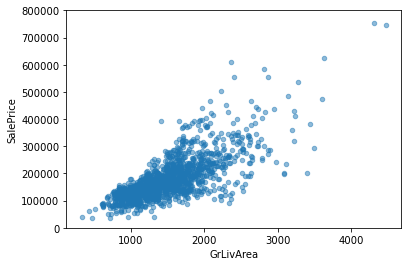

In [20]:
data = pd.concat([train_df['SalePrice'], train_df['GrLivArea']], axis=1)
data.plot.scatter(x='GrLivArea', y='SalePrice', alpha=0.5, ylim=(0,800000));

The two points with SalePrice over 700,000 dollars seem to be following the general trends of each influential variable. For instance, in each catgorical variable, they belong to the, on average, 'highest value' category. For instance, OverallQual of 10, and GarageCars of 3. Intuitively then, it shouldn't confuse the model, and should add robustness.

### 3.2. Normalising 'SalePrice' of Training Data

Use log transformation to transform the target variable.

In [21]:
## Use transformation log(1+x) to be consistent with the transformation of predictor variables

train_df['SalePrice'] = np.log1p(train_df['SalePrice'])

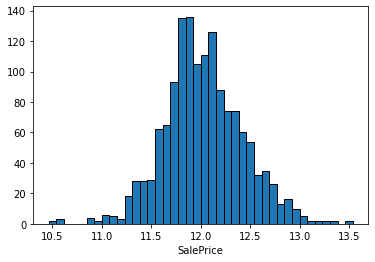

In [22]:
## Distributional summary

plt.hist(train_df['SalePrice'], bins=40, edgecolor='black')
plt.xlabel('SalePrice');

### 3.3. Preparing for Transformations

Our data transformations must be applied to both the training and test set, so our model can make predictions as learned on the training set. As long as we build the model completely independently of the test data, this is fine. For example, finding the median value of a predictor variable accross the training and test set would cause **data leakage**, and our results would be overly optimistic and not representative.

In [23]:
train_targets = train_df['SalePrice']
train_df_vars = train_df.drop(['SalePrice'], axis=1)

all_vars = pd.concat([train_df_vars, test_df]).reset_index(drop=True)
print(all_vars.shape)
print(train_df_vars.shape)
print(test_df.shape)

(2917, 80)
(1458, 80)
(1459, 80)


### 3.4. Missing Values

First need to discover how many entries are null for each dependent variable, and decide on further action to take based on its utility.

In [24]:
## Create a function which returns a dataframe displaying percentge of missing values per column

def col_percent_missing(df):
    missing = (df.isnull().sum()/len(df)) * 100
    missing_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': missing}).sort_values(by='percent_missing', ascending=False)
    return missing_df

In [25]:
## Percentage of missing entries in train_df columns: 

col_percent_missing(all_vars)[0:10]

,column_name,percent_missing
PoolQC,PoolQC,99.691464
MiscFeature,MiscFeature,96.400411
Alley,Alley,93.212204
Fence,Fence,80.425094
FireplaceQu,FireplaceQu,48.680151
LotFrontage,LotFrontage,16.660953
GarageYrBlt,GarageYrBlt,5.450806
GarageFinish,GarageFinish,5.450806
GarageQual,GarageQual,5.450806
GarageCond,GarageCond,5.450806


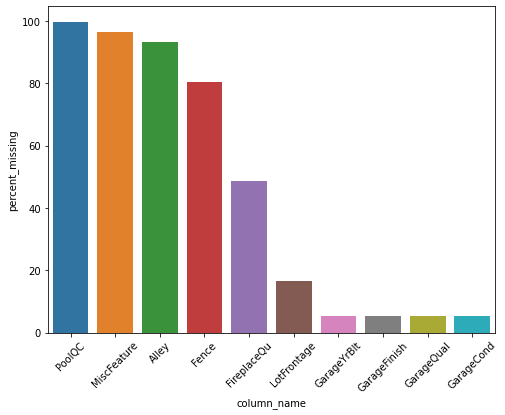

In [26]:
f, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x="column_name", y="percent_missing", data=col_percent_missing(all_vars)[0:10])
plt.xticks(rotation=45);

We should address the columns with >40% missing values. Given more time we could similairly address missing values of each feature in a more careful and thoughtful way for better results.

**Categorical missing data:**
* For 'PoolQC', N/A refers to 'no pool', so fill with 'None'
* For 'GarageType', , 'GarageQual', 'GarageCond', 'GarageFinish', N/A refers to 'no garage', so fill with 'None'
* For N/A entries relating to the basement, 'MiscFeature', and 'FirePlaceQu', similarly fill 'None'
* For 'Functional', fill null with 'Typ' meaning typical, as specified by the data notes

**Numerical missing data:**
* For numerical variables relating to the garage filled 'N/A', enter 0 since no garage


Our data transformations must be applied to both the training and test set, so our model can make predictions as learned on the training set. As long as we apply transformations which are independent of one another, this is fine. For example, finding the median value of predictor variable accross the training and test set would cause **data leakage**, and our results would be overly optimistic and not representative.

In [27]:
fill_na = ['PoolQC', 'GarageType', 'GarageQual', 'GarageCond', 'GarageFinish', 'FireplaceQu',
           'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MiscFeature', 'Fence', 'Alley']

fill_zero = ['GarageYrBlt', 'GarageArea', 'GarageCars']

for col in fill_na:
    all_vars[col] = all_vars[col].fillna('None')
    
for col in fill_zero:
    all_vars[col] = all_vars[col].fillna(0)
    
all_vars['Functional'] = all_vars['Functional'].fillna('Typ')

In [28]:
## Check missing data again

col_percent_missing(all_vars)[0:20]

,column_name,percent_missing
LotFrontage,LotFrontage,16.660953
MasVnrType,MasVnrType,0.822763
MasVnrArea,MasVnrArea,0.788481
MSZoning,MSZoning,0.137127
BsmtFullBath,BsmtFullBath,0.068564
BsmtHalfBath,BsmtHalfBath,0.068564
Utilities,Utilities,0.068564
Exterior2nd,Exterior2nd,0.034282
Electrical,Electrical,0.034282
TotalBsmtSF,TotalBsmtSF,0.034282


Since there is considerable data missing from 'LotFrontage', it's worth implementing a considered and thoughtful way to fill it. Due to time contraints however, I'll drop the column. Then, remaining null values will be filled with 'None' or 0.

In [29]:
all_vars = all_vars.drop(columns='LotFrontage')

remaining_cat = ['Electrical', 'MasVnrType', 'MSZoning', 'Utilities', 'Exterior2nd', 'KitchenQual',
                'Exterior1st', 'SaleType']
remaining_num = ['MasVnrArea', 'BsmtFullBath', 'BsmtHalfBath', 'TotalBsmtSF', 'BsmtUnfSF', 
                 'BsmtFinSF2', 'BsmtFinSF1' ]

for col in remaining_num:
    all_vars[col] = all_vars[col].fillna(0)

for col in remaining_cat:
    all_vars[col] = all_vars[col].fillna('None')

In [30]:
## Check missing data again

col_percent_missing(all_vars)[0:5]

,column_name,percent_missing
Id,Id,0.0
BedroomAbvGr,BedroomAbvGr,0.0
GarageType,GarageType,0.0
FireplaceQu,FireplaceQu,0.0
Fireplaces,Fireplaces,0.0


### 3.4. One-hot Encoding

Need all variables to be numeric, so create one-hot encodings for each variable.

In [31]:
## Split train_df into numerical and categorical dataframes. Note we are missing column 'LotFrontage', hence 80 cols, Id 
## and 'SalePrice' are still included in train_df

all_vars = pd.get_dummies(all_vars).reset_index(drop=True)
all_vars.shape

(2917, 308)

In [32]:
all_vars.head()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_New,SaleType_None,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,8450,7,5,2003,2003,196.0,706.0,0.0,...,0,0,0,1,0,0,0,0,1,0
1,2,20,9600,6,8,1976,1976,0.0,978.0,0.0,...,0,0,0,1,0,0,0,0,1,0
2,3,60,11250,7,5,2001,2002,162.0,486.0,0.0,...,0,0,0,1,0,0,0,0,1,0
3,4,70,9550,7,5,1915,1970,0.0,216.0,0.0,...,0,0,0,1,1,0,0,0,0,0
4,5,60,14260,8,5,2000,2000,350.0,655.0,0.0,...,0,0,0,1,0,0,0,0,1,0


In [33]:
## Split back into train and test set, post transformations

train_df_vars = all_vars.iloc[:len(train_df_vars),:]
test_df = all_vars.iloc[len(train_df_vars):,:]

print(train_df_vars.shape)
print(train_targets.shape)

(1458, 308)
(1458,)


## 4. Model Creation

In [34]:
## Split training set into train and validation set

X_train, X_val , y_train, y_val = train_test_split(train_df_vars, train_targets, test_size = 0.25, random_state = 42)

In [35]:
lireg=LinearRegression()

lireg.fit(X_train, y_train)
y_pred = lireg.predict(X_val)
print(lireg.__class__.__name__, mean_squared_error(y_val, y_pred))

LinearRegression 0.017368064654715295


In [36]:
randfor = RandomForestRegressor(random_state=42)

randfor.fit(X_train, y_train)
y_pred = randfor.predict(X_val)
print(randfor.__class__.__name__, mean_squared_error(y_val, y_pred))

RandomForestRegressor 0.01996307094127327


In [59]:
predictions = np.e**(lireg.predict(test_df))

In [65]:
submission = pd.DataFrame({'Id': range(1461, 2920),
                          'SalePrice': predictions})
submission 

,Id,SalePrice
0,1461,115437.609483
1,1462,100367.827092
2,1463,183438.447210
3,1464,201047.881004
4,1465,191490.448473
...,...,...
1454,2915,80166.875809
1455,2916,84567.517332
1456,2917,163267.978488
1457,2918,115248.161262


In [66]:
submission.to_csv(r'C:\Users\jguze\Documents\Jupyter\houseprices\submission.csv', index = False)